In [1]:
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
df = (pd
    .read_csv(
        'data/crosswriters.csv', 
        encoding='utf-8', 
        usecols=['text', 'author', 'author_gender', 'reader_age_group']
    )
    .astype({
        'author': 'category', 
        'author_gender': 'category', 
        'reader_age_group': 'category'
    })
)
df.sample(10)

,text,author,author_gender,reader_age_group
2184,caroline’s head. she would not even have been ...,Anne Fine,F,child
6561,"self-interest once you’ve baited the hook, it ...",J.K. Rowling,F,adult
1208,"slimy reddened faces. no, what i remember of t...",Anne Fine,F,adult
6508,"had better keep his shoe on, nenita.’ the woma...",J.K. Rowling,F,adult
5744,"wanted to find the stone – find it, but not us...",J.K. Rowling,F,child
1288,"i could stick out my tongue at him, he had gon...",Anne Fine,F,child
6866,"asked kim. “no,” said strike. “notes from her ...",J.K. Rowling,F,adult
1332,‘most helpful person in the class? me?’ ‘i was...,Anne Fine,F,child
1038,harris saw my new name and address. harris pho...,Anne Fine,F,child
272,bed and below the endless sky. it carried our ...,David Almond,M,child


## SVM 

### Child vs Adult

In [3]:
print("Before:", df['reader_age_group'].value_counts(), sep="\n", end="\n\n")

enc = LabelEncoder()
enc.fit(df['reader_age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['reader_age_group'] = enc.transform(df['reader_age_group'])

print("After:", df['reader_age_group'].value_counts(), sep="\n")
encoded_labels

Before:
child    4412
adult    2457
Name: reader_age_group, dtype: int64

After:
1    4412
0    2457
Name: reader_age_group, dtype: int64


{'adult': 0, 'child': 1}

In [12]:
X = df['text']
y = df['reader_age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5495,), (1374,), (5495,), (1374,))

In [13]:
vect = TfidfVectorizer(max_features=5000)
svm  = LinearSVC()
pipe = make_pipeline(vect, svm)

pprint(pipe.get_params(), sort_dicts=False)

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
           ('linearsvc', LinearSVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_features=5000),
 'linearsvc': LinearSVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': <class 'numpy.float64'>,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use

In [14]:
param_grid = {
    # 'linearsvc__C': [0.1, 1, 10],
    # 'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__class_weight': ['balanced', None],
    # 'tfidfvectorizer__analyzer': ['word', 'char'],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # 'tfidfvectorizer__max_df': [0.5, 0.75, 1.0],
    # 'tfidfvectorizer__stop_words': ['english', None],
    'tfidfvectorizer__lowercase': [False]  # already lowercased
}

In [15]:
gs = GridSearchCV(
    pipe, 
    param_grid, 
    cv=10, 
    scoring='accuracy', 
    n_jobs=1, 
    refit=True, 
    verbose=5
)
gs.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.987 total time=   8.5s
[CV 2/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.996 total time=   7.9s
[CV 3/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.995 total time=   7.7s
[CV 4/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.995 total time=   7.8s
[CV 5/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.993 total time=   7.3s
[CV 6/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.991 total time=   7.4s
[CV 7/10] END linearsvc__class_we

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=5000)),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=1,
             param_grid={'linearsvc__class_weight': ['balanced', None],
                         'tfidfvectorizer__lowercase': [False],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             scoring='accuracy', verbose=5)

In [17]:
print("Best score:", gs.best_score_, end="\n\n")
print("Best params:", gs.best_params_)
print("Best estimator:", gs.best_estimator_, end="\n\n")
print("Best estimator params:", gs.best_estimator_.get_params())

Best score: 0.9936300712038417

Best params: {'linearsvc__class_weight': None, 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__ngram_range': (1, 1)}
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, max_features=5000)),
                ('linearsvc', LinearSVC())])

Best estimator params: {'memory': None, 'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_features=5000)), ('linearsvc', LinearSVC())], 'verbose': False, 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_features=5000), 'linearsvc': LinearSVC(), 'tfidfvectorizer__analyzer': 'word', 'tfidfvectorizer__binary': False, 'tfidfvectorizer__decode_error': 'strict', 'tfidfvectorizer__dtype': <class 'numpy.float64'>, 'tfidfvectorizer__encoding': 'utf-8', 'tfidfvectorizer__input': 'content', 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_rang

In [18]:
y_pred = gs.predict(X_test)

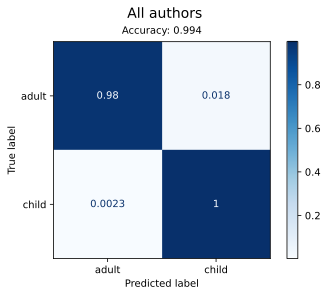

In [80]:
palette = sns.color_palette('gist_stern_r', as_cmap=True)
classes = [label for label in encoded_labels]
title = "All authors"

disp = ConfusionMatrixDisplay.from_estimator(
    gs,
    X_test,
    y_test,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize='true',
)

plt.suptitle(title, y=1, fontsize=14)
disp.ax_.set_title(f"Accuracy: {gs.best_score_:.3f}", fontsize=10, pad=8)
disp.ax_.tick_params(axis='x');